# Exploratory factor analysis

**Analysis steps:**

1. [📓 Questionnaire processing.ipynb](<Questionnaire processing.ipynb>)
2. ▶ **[📓 Factor analysis.ipynb](<Factor analysis.ipynb>)**
3. [📓 Prediction analysis.ipynb](<Prediction analysis.ipynb>)
4. [📓 Prediction modelling.ipynb](<Prediction modelling.ipynb>)

This notebook performs exploratory factor analysis on the questionnaire data.


## Imports

In [3]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import skew
from stats_utils.efa.plotting import plot_scree
from statsmodels.formula.api import ols
from tqdm import trange

from interactive_avoidance.style import set_style
from interactive_avoidance.utils import check_directories

# Check that we're in the right directory
check_directories()

set_style("style.mplstyle")

Font saved to: ./fonts
Matplotlib style set to: style.mplstyle with font Heebo


## Load data


In [4]:
# Read the dataset from the specified path
data = pd.read_csv("data/questionnaires/combined_efa_questionnaire_data.csv")

# Store subjectID and study columns in a separate dataframe for later use
subjectID_study = data[["subjectID", "study"]]

# Remove the 'subjectID' and 'study' columns from the dataframe
data = data.drop(columns=["subjectID", "study"])

# Load item-level data
questionnaire_data = pd.read_csv(
    "data/questionnaires/questionnaire_data_wide-reverse_coded.csv"
)

# Load scale-level data (just because this contains the attention check info)
attention_checks = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)
attention_checks = attention_checks[
    attention_checks.columns.intersection(
        ["subjectID", "attention_check_failed", "inattentive_incorrect"]
    )
]
questionnaire_data = questionnaire_data.merge(attention_checks, on="subjectID")

# Extract demographic details from the questionnaire data
demographics = questionnaire_data[["subjectID", "age", "gender"]]

## Clean up data

### Remove items with highly skewed responses

We want to avoid including items with strong response bias, and hence skewed responses. We can remove items with skewness greater than 2 or less than -2.


In [5]:
# Calculate skewness for each column in the data
q_skewness = data.apply(skew)

# Filter columns in the data with absolute skewness values less than 2
data = data.loc[:, abs(q_skewness) < 2]

### Compute correlation matrix


In [6]:
# Compute correlation matrix and round to 2 decimal places
cormat = data[sorted(data.columns)].corr().round(2)

### Remove high correlations

Here we remove items with absolute correlations of > .7


In [7]:
# Set the diagonal of the correlation matrix to zero
np.fill_diagonal(cormat.values, 0)

# Create a matrix of absolute correlations
abs_cormat = abs(cormat)

# Find the maximum absolute correlation for each variable
max_corr = abs_cormat.max()

# Check if any variable has a correlation greater than 0.7 with any other variable
any_high_corr = (max_corr > 0.7).any()

print(any_high_corr)

True


There are some items with high correlations - see where these correlations are


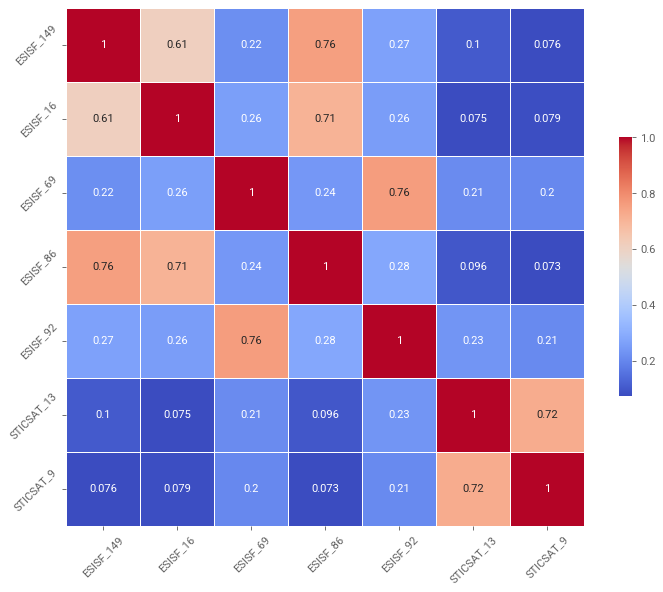

In [8]:
# Compute the correlation matrix for variables with a maximum absolute correlation greater than 0.7
high_corrs = data.loc[:, max_corr > 0.7].corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    high_corrs,
    annot=True,
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"size": 10},
)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

A few items are highly correlated - we can remove them.


In [9]:
# Define a list of items to be removed
removed_items = ["ESISF_92", "ESISF_16", "ESISF_69", "ESISF_149", "STICSAT_13"]

# Remove the specified items from the dataframe
cleaned_data = data.drop(columns=removed_items)

## Run exploratory factor analysis

Here we run the exploratory factor analysis using the [`factor_analyzer`](https://factor-analyzer.readthedocs.io/en/latest/index.html) package. We use the `ml` method, which uses maximum likelihood estimation, and use the `oblimin` rotation method, which allows for correlated factors.

We extract the eigenvalues for the factors (`ev`), and store them in a dataframe which is then saved to a csv file.


In [10]:
# Check for suitability for factor analysis
kmo_all, kmo_model = calculate_kmo(cleaned_data)
bartlett_sphericity = calculate_bartlett_sphericity(cleaned_data)
print("KMO Test: ", kmo_model)
print("Bartlett's Test: ", bartlett_sphericity)

# Fit factor analysis model to the data
fa = FactorAnalyzer(
    n_factors=cleaned_data.shape[1],
    rotation="oblimin",
    method="ml",
    is_corr_matrix=False,
)
fa.fit(cleaned_data)
ev, _ = fa.get_eigenvalues()

# Save eigenvalues to a DataFrame
ev_df = pd.DataFrame(ev, columns=["Eigenvalues"])

# Create a directory to save the eigenvalues within the ./results/questionnaires
if not os.path.exists("results/questionnaires/efa"):
    os.makedirs("results/questionnaires/efa")

# Save the eigenvalues to a csv file
ev_df.to_csv("results/questionnaires/efa/eigenvalues.csv", index=False)

/home/tobywise/miniconda3/envs/ia_env/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO Test:  0.9584534391881901
Bartlett's Test:  (85984.65553504194, 0.0)


### Plot scree plot

We can plot the scree plot to see how many factors to retain. There is an elbow at 4 factors, so we retain 4 factors.


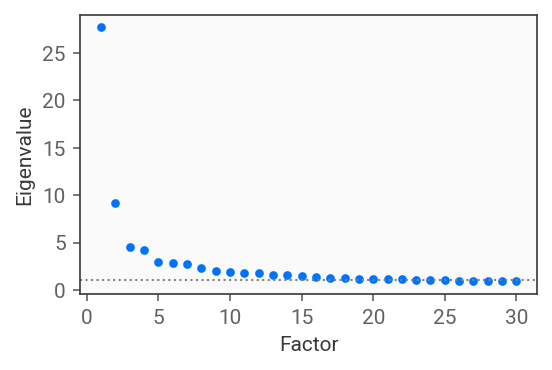

In [11]:
plot_scree(ev)

# Save
plt.savefig("figures/efa/scree_plot.svg", dpi=300)

## Save results for different numbers of factors

We want to investigate relationships with a hierarchy of symptom dimensions, so we re-run the factor analysis for 1-4 factors, and save the results for each number of factors.


In [12]:
# Key for renaming factors
factor_key = [
    {
        "ML1": "General",
    },
    {
        "ML1": "Internalising",
        "ML2": "Externalising",
    },
    {
        "ML1": "Internalising",
        "ML2": "Externalising",
        "ML3": "Withdrawal",
    },
    {
        "ML1": "Externalising",
        "ML2": "Internalising",
        "ML3": "Withdrawal",
        "ML4": "Inattention",
    },
]

# Initialize a list to store factor scores from each iteration
all_factor_scores = []

# Create efa/hierarchical directory if it doesn't exist
os.makedirs("results/questionnaires/efa/hierarchical", exist_ok=True)

for i in trange(1, 5):
    # Run factor analysis with a varying number of factors
    fa_model = FactorAnalyzer(n_factors=i, rotation="oblimin", method="ml")
    fa_model.fit(cleaned_data)

    # Extract factor loadings
    loadings = pd.DataFrame(fa_model.loadings_.squeeze(), index=cleaned_data.columns)

    # Extract measure name and assign item number and item name to the loadings dataframe
    loadings["measure"] = loadings.index.to_series().apply(
        lambda x: re.search("(.+(?=_))", x).group(1)
    )
    loadings["itemNumber"] = range(1, len(loadings) + 1)
    loadings["item"] = loadings.index

    # Sort loadings by item
    # Split the "item" column into measure and item number columns based on the _ character
    loadings[["sort_measure", "sort_number"]] = loadings["item"].str.split(
        "_", expand=True
    )
    loadings["sort_number"] = loadings["sort_number"].astype(int)

    # Sorting by the new numeric 'sort_key'
    loadings = loadings.sort_values(["sort_measure", "sort_number"]).drop(
        ["sort_measure", "sort_number"], axis=1
    )

    # Replace 0, 1, 2 etc. with ML1, ML2, ML3 etc.
    loadings.columns = [f"ML{i}" for i in range(1, i + 1)] + [
        "measure",
        "itemNumber",
        "item",
    ]

    # Save factor loadings to a CSV
    loadings.to_csv(
        f"results/questionnaires/efa/hierarchical/factor_loadings__{i}.csv", index=False
    )

    # Extract and save factor scores to a CSV
    scores = pd.DataFrame(fa_model.transform(cleaned_data))
    # Set columns to ML1, ML2, ML3, etc. in line with R
    scores.columns = [f"ML{i}" for i in range(1, i + 1)]

    # Append the current factor scores to the cumulative list
    all_factor_scores.append(scores)

    # Add subjectID and study columns
    scores["subjectID"] = subjectID_study["subjectID"]
    scores["study"] = subjectID_study["study"]

    # Select scores only for the predator study
    scores = scores.loc[scores["study"] == "predator"]

    # Merge with demographics
    scores = pd.merge(scores, demographics, on="subjectID")

    # Save factor scores to a CSV
    scores.to_csv(
        f"results/questionnaires/efa/hierarchical/factor_scores__{i}.csv", index=False
    )

    # Label columns
    scores = scores.rename(columns=factor_key[i - 1])

    # Save named factor scores to a CSV
    scores.to_csv(
        f"results/questionnaires/efa/hierarchical/factor_scores__{i}-named.csv",
        index=False,
    )

  0%|          | 0/4 [00:00<?, ?it/s]/home/tobywise/miniconda3/envs/ia_env/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(
100%|██████████| 4/4 [00:46<00:00, 11.64s/it]


## Get factor scores

The 4 factor solution appears to be the interpretable and has a good number of primary loadings for each factor.

These factors represent:

1. Mood
2. Externalising
3. Withdrawal
4. Neurodevelopmental/inattention

Here we load in the scores for each solution, combine them with demographic information and save. We also create a list (`all_factor_scores`) containing all solutions for further analysis.


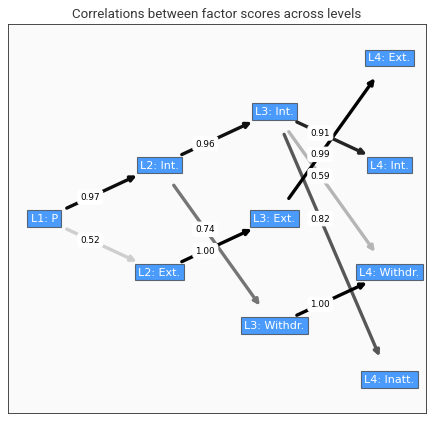

In [13]:
import networkx as nx
from stats_utils.efa.plotting import plot_factor_correlations


# Factor labels, incorporating factor names and level in hierarchivy
labels = {
    0: "L1: P",
    1: "L2: Int.",
    2: "L2: Ext.",
    3: "L3: Int.",
    4: "L3: Ext.",
    5: "L3: Withdr.",
    6: "L4: Ext.",
    7: "L4: Int.",
    8: "L4: Withdr.",
    9: "L4: Inatt.",
}

# all_factor_scores is a list of dataframes with factor scores
# currently the columns are out of order, so we need to reorder them
# we can do this by sorting the columns alphabetically
all_factor_scores = [df.reindex(sorted(df.columns), axis=1) for df in all_factor_scores]

# Plot
plot_factor_correlations(all_factor_scores, labels=labels)

### Plot factor loadings


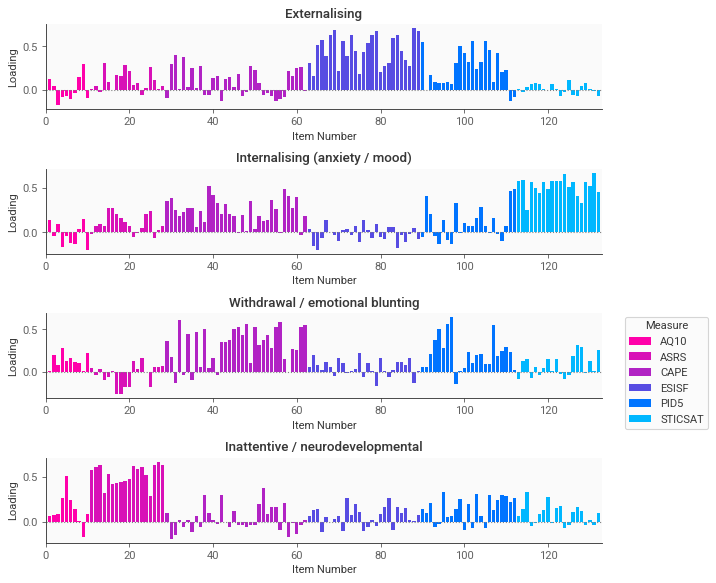

In [14]:
from stats_utils.efa.plotting import plot_factor_loadings

_ = plot_factor_loadings(
    "results/questionnaires/efa/hierarchical/factor_loadings__4.csv",
    [
        "Externalising",
        "Internalising (anxiety / mood)",
        "Withdrawal / emotional blunting",
        "Inattentive / neurodevelopmental",
    ],
)

# Save
plt.savefig("figures/efa/efa_factor_loadings.svg", bbox_inches="tight")

## Look at effects on motivation and fear of the predator


In [15]:
# combine summed data and factor data for 6-factor solution
factor_scores = pd.read_csv(
    "results/questionnaires/efa/hierarchical/factor_scores__4-named.csv"
).drop(columns=["age", "gender"])

# Load in questionnaire data with sumscores
questionnaire_data_sumscores = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)

# merge with summed_data
factors_sumscores = pd.merge(
    factor_scores, questionnaire_data_sumscores, on="subjectID"
)

### Associations between factor scores and motivation/fear


In [16]:
# run regression predicting 0motivation from all factors in 4 factor model
model = ols(
    "motivation ~ age + gender + Internalising + Externalising + Inattention  + Withdrawal",
    data=factors_sumscores,
).fit()

# print summary
print(model.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        87.8316      1.669     52.616      0.000      84.556      91.107
age              -0.0045      0.043     -0.104      0.917      -0.089       0.080
gender           -2.0931      1.066     -1.963      0.050      -4.186      -0.001
Internalising     1.1067      0.736      1.503      0.133      -0.338       2.552
Externalising    -0.0989      0.589     -0.168      0.867      -1.254       1.056
Inattention       0.2369      0.660      0.359      0.720      -1.058       1.531
Withdrawal       -1.9333      0.632     -3.059      0.002      -3.174      -0.693


In [17]:
# run regression predicting 0motivation from all factors in 4 factor model
model = ols(
    "scared ~ age + gender + Internalising + Externalising + Inattention  + Withdrawal",
    data=factors_sumscores,
).fit()

# print summary
print(model.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        65.5659      2.892     22.671      0.000      59.891      71.241
age              -0.3245      0.075     -4.341      0.000      -0.471      -0.178
gender            5.2038      1.847      2.817      0.005       1.579       8.829
Internalising     6.0246      1.276      4.722      0.000       3.521       8.528
Externalising    -1.7011      1.020     -1.668      0.096      -3.703       0.300
Inattention       1.9036      1.143      1.666      0.096      -0.339       4.146
Withdrawal       -2.0241      1.095     -1.848      0.065      -4.173       0.125


## Build combined figure


/mnt/c/Users/tobyw/OneDrive-KCL/tools/stats-utils/stats_utils/stats/plotting.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


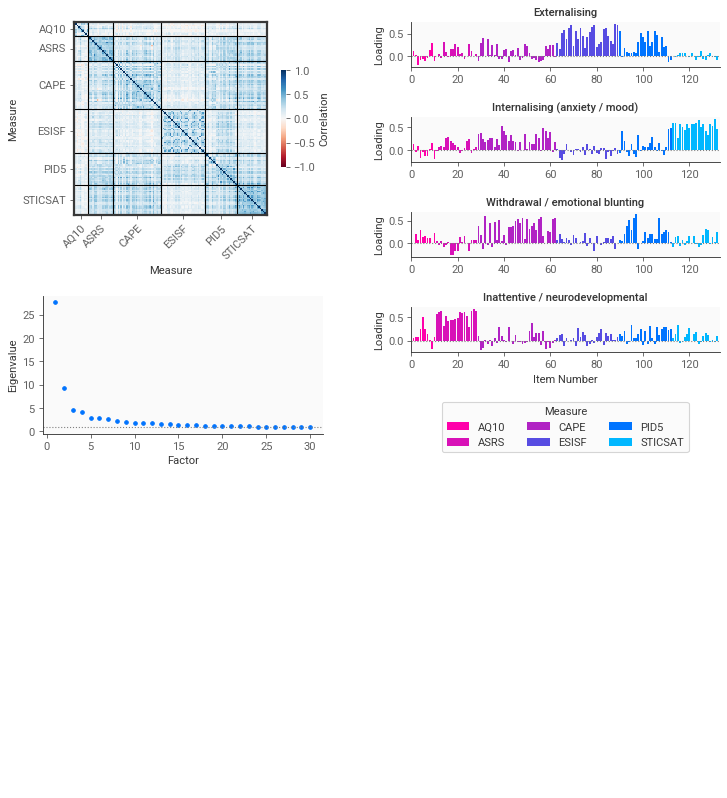

In [119]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from stats_utils.stats.plotting import plot_grouped_corr_heatmap

# Create a figure
fig = plt.figure(figsize=(9, 12))

# Define GridSpec
gs = gridspec.GridSpec(
    3, 2, height_ratios=[1.4, 1, 2], width_ratios=[1, 1.1], wspace=0.3
)

# Add subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
# ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
ax3 = fig.add_subplot(gs[1, 0])  # Second row, first column
# ax4 = fig.add_subplot(gs[1, 1])  # Second row, second column

# Now define a nested GridSpec for the bottom left, with 4 rows and 1 column
nested_gs = gridspec.GridSpecFromSubplotSpec(
    5, 1, subplot_spec=gs[0:2, 1], height_ratios=[1, 1, 1, 1, 0.7], hspace=1.2
)

# Add subplots for the nested GridSpec
ax5 = fig.add_subplot(nested_gs[0])
ax6 = fig.add_subplot(nested_gs[1])
ax7 = fig.add_subplot(nested_gs[2])
ax8 = fig.add_subplot(nested_gs[3])
ax9 = fig.add_subplot(nested_gs[4])

# Blank subplot for later use
ax10 = fig.add_subplot(gs[2, 0])  # First row, first column
ax10.axis("off")

# Plot correlation matrix
plot_grouped_corr_heatmap(
    data,
    heatmap_kwargs={"linewidths": 0, "vmax": 1, "vmin": -1},
    subplot_kwargs={"figsize": (7, 7)},
    ax=ax1,
    axis_labels="Measure",
    grouping_linewidth=1,
)

# Plot scree
ax3.set_position([10, 0.5, 0.4, 0.4])
plot_scree(ev, ax=ax3)
sns.despine(ax=ax3)

# Plot factor loadings
plot_factor_loadings(
    "results/questionnaires/efa/hierarchical/factor_loadings__4.csv",
    [
        "Externalising",
        "Internalising (anxiety / mood)",
        "Withdrawal / emotional blunting",
        "Inattentive / neurodevelopmental",
    ],
    ax=[ax5, ax6, ax7, ax8],
    adjust_spacing=False,
)

# Hide axes for ax9
ax9.axis("off")

# Move legend to top
ax8.legend(loc="upper center", bbox_to_anchor=(0.5, -1), ncol=3, title="Measure")


# Adjust font size for the titles of the subplots
for ax in [ax5, ax6, ax7, ax8]:
    ax.title.set_fontsize(10)

# Remove x-axis labels for ax5, ax6, ax7
for ax in [ax5, ax6, ax7]:
    ax.set_xlabel("")

# plt.tight_layout()
plt.subplots_adjust(left=0.01, bottom=0.08, wspace=0.0, hspace=0.4)

# Save
if not os.path.exists("figures/combined"):
    os.makedirs("figures/combined")
plt.savefig("figures/combined/figure2.svg", bbox_inches="tight")
plt.savefig("figures/combined/figure2.pdf", bbox_inches="tight")